# Using Multi Agent Reinforcement Learning to solve Vehicle Rescheduling Problem

## D1. Decomposition

Scheduling trains to arrive at destination on time with minimal delays in shared network is an enormously valuable problem, but is mathematically NP-hard. Traditionally, this problem is solved through tools and methods in the field of Operation Research such as CPLEX, SAV, PA, CFN etc. Due to the NP-Hard nature of the problem, the running of these tools often scale non-linearly as the problem gets larger and larger. As a consequence, on one hand, these tools provide superior performance for initial route planning as they theoretically have infinite amount of time and resource to calculate. On the other hand, once a disruption in the network happens (such as train breaks down, slow loading of cargo, human accidents in the rail, etc), these tools are forced to recalculate their route planning for all trains in the network under time and resource limitations and often fail to deliver a solution on time.

We propose solving this problem under a Multi-Agent Reinforcement Learning approach by building a system that continuously trains an agent on a variety of network situation. Our training framework results in a fixed size neural network acting as an agent that makes decisions on the fly on whether the trains should break, reverse, turn left or turn right at each intersection. Framing the problem as a MARL problem provides several advantages:

1. Each agent is controlled by a fixed-sized neural network. Therefore, introducing a new agent will only add a linear complexity to the problem. In fact, it is possible to use the very same network for the new agent. The new agent decision making will cost the same amount of time as any other agents.
2. Reinforcement Learning method has been shown to adapt gracefully to change in situations since these changes are already accounted for during the training process. When one train broke down and stopped in the middle of the track, this only resulted in a changed input to the network. The agent should readily adapt without triggering total path recalculation as in the OR methods \cite{igl2019generalization}.
3. If the agent is already trained in a variety of rail network environments, then it can readily adapt when a new path is introduced to the network. The agent should be able to readily operate with the newly introduced path to the network.

Thus, providing that the agents are trained in a sufficiently large and diverse set of rail network environments, we potentially transform all the expensive re-scheduling costs of OR methods into upfront training cost of Machine Learning. The recalculation time limit merely becomes the inference time limit for the neural network model. With the recent advances in GPU computing, this is a non-issue; it has been shown time and time again that several minutes are more than enough even for extremely large neural network models with billions of parameters.

## D2. Domain expertise

We theorized that the agents must be trained in a sufficiently large and diverse set of rail networks. Therefore, the most important aspect of the project will be the rail network generations. The networks have to both closely match the real world and be as diverse as possible

We model our track based on the guideline provided by the [Flatland simulation](https://flatland.aicrowd.com/getting-started/env.html). According to Flatland simulation, we need tracks and 7 different types of transitions to model any rail networks in the world. We also know that while real world track is rarely a straightline, the curvature of track does not matter for logistical planning purpose; the entire line of track can be reduced to a single line, with a position indicating where the train is in the track.

<img src="../paper/img/TypesOfSwitches.PNG" width="700">

Given this track and transition model, we can abstract any real-world railroad network into a graph into our simulation. We can also randomly generate graphs that are reasonably close to real-world maps

## D3. Data generation

We were not able to find a suitable simulation for this problem and decided to create our own. We theorize that if the agents are trained in a diverse rail network environments, then during deployment, it will be able to adapt when the network has a change, or when new trains are added. To show this, we will walk through how we generated the rail network.

### Step 1: Define transition types and degrees

Note that each transition can be thought of as a vertex in the graph that connects to a certain number other nodes (i.e. node degree). For example, a dead-end transition only connects to one other node, while a double slip switch connects to 4 nodes. Thus, this problem can be converted to generate a degree sequence, and a graph that matches that sequence. We first define each type of transition and their respective degrees.

In [39]:
from enum import Enum

class TransitionType(Enum):
    STRAIGHT = 1
    SIMPLE_SWITCH = 2
    THREE_WAY_SWITCH = 3
    DIAMOND_CROSSING = 4
    SINGLE_SLIP_SWITCH = 5
    DOUBLE_SLIP_SWITCH = 6
    DEAD_END = 7
type_degrees = {
    TransitionType.DEAD_END: 1,
    TransitionType.STRAIGHT: 2,
    TransitionType.SIMPLE_SWITCH: 3,
    TransitionType.THREE_WAY_SWITCH: 3,
    TransitionType.DIAMOND_CROSSING: 4,
    TransitionType.SINGLE_SLIP_SWITCH: 4,
    TransitionType.DOUBLE_SLIP_SWITCH: 4
}

### Step 2: Generate a random degree sequence based on the number of transitions.

Given the number of transitions, we will generate a sequence of random transition types, which represent the actual transtions that will reside in the network.

In [40]:
import numpy as np

# RNG for graph generations
rng = np.random.default_rng(42)

# Define the number of transitions, and the probability of each transition types
num_transitions = 15
type_choices = [
    TransitionType.DEAD_END,
    TransitionType.STRAIGHT,
    TransitionType.SIMPLE_SWITCH,
    TransitionType.THREE_WAY_SWITCH,
    TransitionType.DIAMOND_CROSSING,
    TransitionType.SINGLE_SLIP_SWITCH,
    TransitionType.DOUBLE_SLIP_SWITCH
]
choice_probability = [0, 0.15, 0.15, 0.25, 0.15, 0.15, 0.15]

# Generate the degree sequence until the sum of degree sequence is divisible by 2
while True:
    trans_sequence = list(
        rng.choice(type_choices, num_transitions, replace=True, p=choice_probability))
    deg_sequence = [type_degrees[trans_type] for trans_type in trans_sequence]
    if sum(deg_sequence) % 2 == 0:
        break
        
print(deg_sequence)

[4, 3, 4, 4, 2, 4, 4, 4, 2, 3, 3, 4, 4, 4, 3]


### Step 3: Generate the graph based on degree sequence

We used the `networkx` libraries to generate our graph based on the given degree sequence. We will do this a few times to make sure that the graph is fully connected.

After the graph is generated, we will do some post processing, where:

* Each self-loop is extended into a `DEAD_END`.
* Each parallel-edge will form a new `STRAIGHT` to represent a parallel but longer path.

In [3]:
import networkx as nx

# Generate a grpah based on the given degree sequence
num_retries = 10
graph_seed = 100
for _ in range(num_retries):
    G = nx.configuration_model(deg_sequence=deg_sequence, seed=graph_seed)
    if not nx.is_connected(G):
        graph_seed += 1
    else:
        break
        
# Post processing
edges = list(G.edges)
unique_edge_set = set()
nx.set_edge_attributes(G, 1, "weight")
for e in edges:
    # Self loop:
    if e[0] == e[1]:
        G.remove_edge(*e)
        new_node_id = len(G.nodes)
        G.add_edge(e[0], new_node_id, weight=2)
        trans_sequence.append(TransitionType.DEAD_END)
        if G.degree(e[0]) == 3:
            trans_sequence[e[0]] = rng.choice(
                [TransitionType.SIMPLE_SWITCH, TransitionType.THREE_WAY_SWITCH])
        elif G.degree(e[0]) == 2:
            trans_sequence[e[0]] = TransitionType.STRAIGHT

    # Parallel edges:
    if (e[0], e[1]) in unique_edge_set:
        G.remove_edge(*e)
        new_node_id = len(G.nodes)
        G.add_edge(e[0], new_node_id, weight=3)
        G.add_edge(e[1], new_node_id, weight=3)
        trans_sequence.append(TransitionType.STRAIGHT)
    else:
        unique_edge_set.add((e[0], e[1]))
        
print(G)
for e in G.edges:
    print("{0:d} - {1:d}".format(e[0], e[1]))

MultiGraph with 20 nodes and 28 edges
0 - 5
0 - 6
0 - 1
0 - 12
1 - 7
1 - 5
2 - 6
2 - 11
2 - 7
2 - 15
3 - 4
3 - 12
3 - 13
3 - 16
4 - 13
5 - 6
5 - 8
6 - 10
7 - 9
7 - 15
8 - 13
9 - 12
9 - 14
10 - 17
11 - 13
11 - 18
12 - 16
14 - 19


### Step 4: "Spring" and scale the graph

"Springing" the graph is the process of using force simulation so that each node has appropriate distance from each other. In this algorithm, each node exert a push to other nodes, but each edge pull the node toward each other. This way, densely connected nodes will be close together, while sparsely connected nodes will be far apart. This algorithm is very commonly used for graph visualization, but we also found that it creates network with very diverse shapes

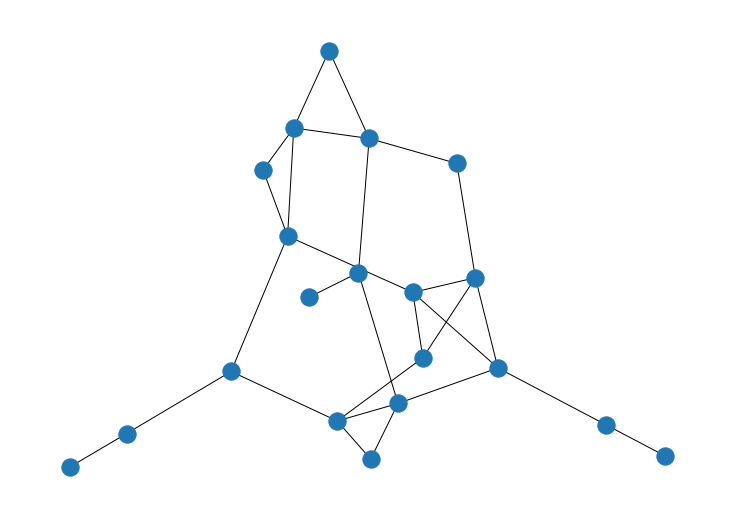

In [4]:
import math
import matplotlib.pyplot as plt

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1))

# Spring the graph
position_seed = 105
node_positions = nx.spring_layout(G, seed=position_seed, iterations=100, weight="weight")

# Scale the position of each node so that the average distance of each section is the specified average section
# length.
average_section_length = 400
total_track_length = 0
num_edges = 0
for e in G.edges:
    total_track_length += euclidean_distance(
        node_positions[e[0]][0], node_positions[e[0]][1],
        node_positions[e[1]][0], node_positions[e[1]][1])
    num_edges += 1
scaling_factor = average_section_length / (total_track_length / num_edges)
for n in node_positions:
    node_positions[n][0] = (node_positions[n][0] + 1) / 2 * scaling_factor
    node_positions[n][1] = (node_positions[n][1] + 1) / 2 * scaling_factor

plt.figure(figsize=(10, 7))
nx.draw(G, node_positions)
plt.show()

Note that because there is randomness in almost all steps of graph generations, we can generate a different graph simply by changing any of the following factors:

* Number of transitions
* Distribution of transition types
* Transition selection seed
* Graph seed
* Position seed

Therefore, we can generate a very diverse array of graphs by randomly change one of the randomness factors above. We package the entire graph generation methods into a class called `TrackMapGenerator`. The following shows examples of graphs with 10 transitions randomly generated.

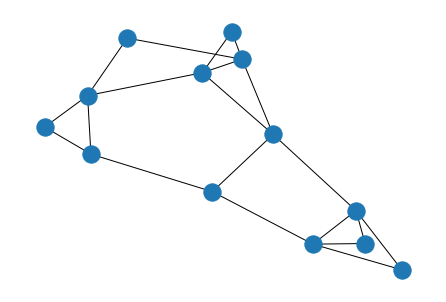

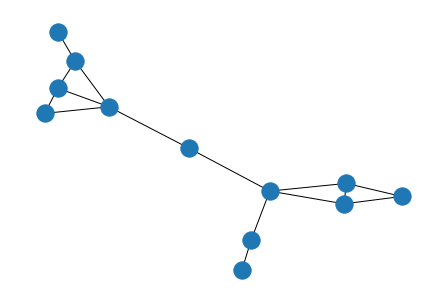

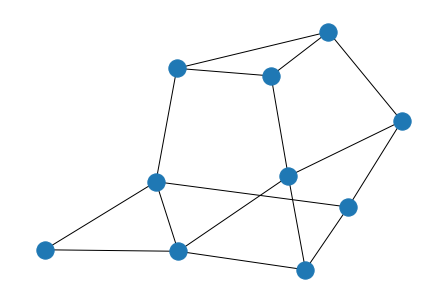

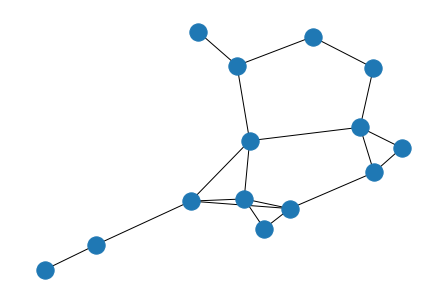

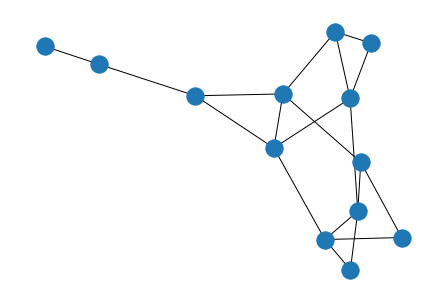

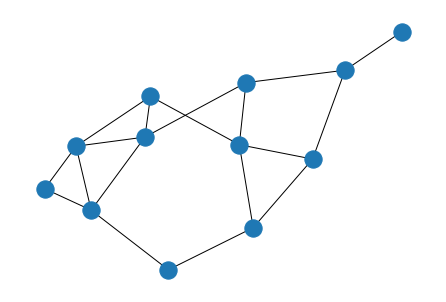

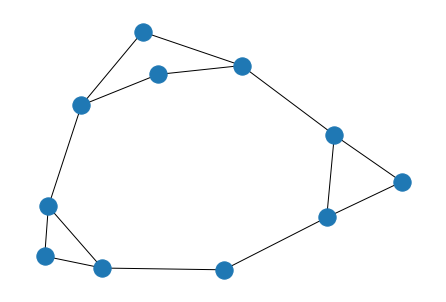

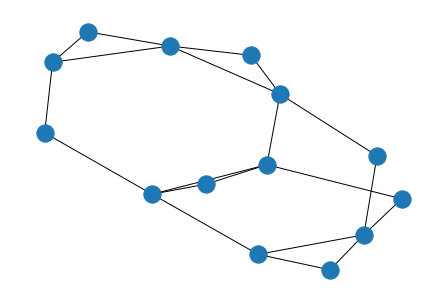

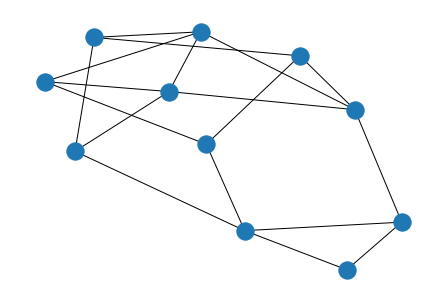

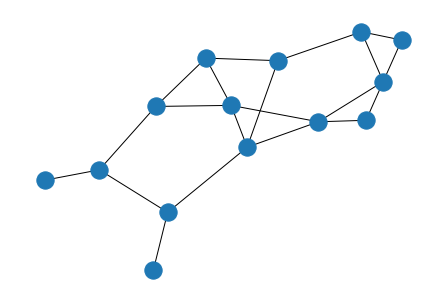

In [5]:
from train_sim.track_map_utils import TrackMapGenerator

tmg = TrackMapGenerator(
    average_section_length=200,
    num_transitions=10,
    rng_seed=53)
for i in range(10):
    _, G, node_positions = tmg.generate_next_map()
    nx.draw(G, node_positions)
    plt.show()

### Step 5: Place the trains' starting and destination position

Once a graph is generated, trains' starting position and destination position can be randomly placed in the graph to form a problem.

Obviously, it would be very difficult and subjective to judge whether a rail network is diverse and matches closely with a network in reality. The best method is to actually construct these graphs from Google Maps' image of rail networks, but we unfortunately don't have enough resources to conduct this data collection and has to settle for procedural content generation as we have described. In our own opinion, the generated rail networks look reasonably realistic and are diverse enough as training data. We will show some examples here and leave it to the readers to decide the diversity and realism of the networks.

<img src="../paper/img/DataGeneration.PNG" width="1000">

As Matplotlib is not able to visualize the train simulation in real time within a notebook, we created the file [`main_track_generator.py`](./main_track_generator.py) to show how the simulation works when there are real trains within the network. Those who are interested in what the simulation looks like can run

```
python3 main_track_generator.py
```

## D4. Model design

### Feature generation

The details of how features are generated is described in details in the paper. But in essence, because each rail network is a graph, each agent can look ahead several branch from where it is like the following diagram:

<img src="../paper/img/Branching.PNG" width="600">

For each branch, we will collect some features related to the branch such as:

* Remaining distance to complete the branch
* Whether there is a potential conflict with other trains in that branch.
* Total distance to target if the branch is taken etc.
* ...

These numerical values is then stacked together into one set of features. If there isn't an existing branch, the value `-1` is filled in.

<img src="../paper/img/FeatureVector.PNG" width="600">

The full list of features is documented in the paper. The following code generates a sample set of features where users can input their observation depth. An important thing to note is that the feature size increase geometrically as the user increase the observation depth. Therefore, users need to tune the observation depth carefully to balance the trade off between information and model size.

In [2]:
from rl.agent import DefaultAgent, RandomAgent
from rl.observation import TreeObserver
from train_sim.simulation import Simulation, SimulationParams
from train_sim.track_map_utils import TrackMapGenerator

# Create a sample back end map
tmg = TrackMapGenerator(400, 12)
sim_params = SimulationParams(10.0, 0.02, 10, 0.70, 300, 0.4, 0.0001, 10000, 100)
simulation = Simulation(tmg.generate_next_map()[0], sim_params)

# Assign AI to the trains
for i, train in enumerate(simulation.train_fleet):
    train.set_agent(RandomAgent(train, TreeObserver(train, simulation, observation_depth=i), simulation.rng))
    
simulation.step()
    
for i, train in enumerate(simulation.train_fleet):
    obs, _ = train.get_agent_state_and_actions()
    print("Depth: {0:d}, Feature size: {1:d}".format(i, len(obs)))
    print(obs)
    print()

Depth: 0, Feature size: 0
[]

Depth: 1, Feature size: 36
[ 0.43250747  1.         -0.24369251  1.          0.08263791  1.
 -0.51326025  0.          1.          1.          1.          0.1
  1.          1.          0.          0.          1.          0.
  0.17289025  1.         -0.32516366  0.          0.          0.
  0.          1.          0.36439946  1.          0.          0.
  1.          0.          0.          0.          1.          0.        ]

Depth: 2, Feature size: 108
[0.10628531 0.         0.         0.         0.         0.
 0.         0.         1.         0.08357599 0.         0.
 1.         0.         0.         0.         1.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.03576586 0.         0.
 1.         0.         0.         0.         1.         0.
 1.         0.         0.         1.         0.74421738 0.
 0.         1.         0.57550647 1.         0.         0.
 1.         0.         0.         0.      

### Model selection

For the model, we have two candidate models in mind:

* [Dueling DQN model](https://arxiv.org/pdf/1511.06581.pdf)
* [CommNet](https://arxiv.org/abs/1605.07736)

Both models are implemented within `rl/models` folder. In this notebook, we will simply walk through how the Dueling DQN model is created, and how one episode of training the Dueling DQN is conducted. The code of the Dueling DQN model can be viewed below:

```python
class DuelingQNetwork(nn.Module):
    """Dueling Q-network (https://arxiv.org/abs/1511.06581)"""

    def __init__(self, state_size, action_size, hidsize1=128, hidsize2=128):
        super(DuelingQNetwork, self).__init__()

        # value network
        self.fc1_val = nn.Linear(state_size, hidsize1)
        self.fc2_val = nn.Linear(hidsize1, hidsize2)
        self.fc4_val = nn.Linear(hidsize2, 1)

        # advantage network
        self.fc1_adv = nn.Linear(state_size, hidsize1)
        self.fc2_adv = nn.Linear(hidsize1, hidsize2)
        self.fc4_adv = nn.Linear(hidsize2, action_size)

    def forward(self, x):
        val = F.relu(self.fc1_val(x))
        val = F.relu(self.fc2_val(val))
        val = self.fc4_val(val)

        # advantage calculation
        adv = F.relu(self.fc1_adv(x))
        adv = F.relu(self.fc2_adv(adv))
        adv = self.fc4_adv(adv)

        return val + adv - adv.mean()
```

A full explanation of the model can be viewed in the [Research Paper](paper/paper.PDF).

### Step 1: Set up training parameters.

There are 5 types of paramters that we have to set up to train the model:
    
1. **Model training parameters:** These will decide training parameters such as number of training episodes, beginning `epsilon` value, `epsilon` decay rate.
2. **Obveration parameters:** Deciding on the depth of observation for each agent.
3. **Model parameters:** Deciding on the architecture of the model
4. **Simulation parameters:** Deciding on configuration and fidelity of the simulation such as the time limit, number of trains, time step interval, speed of the train, length of the train compared to its starting track location.
5. **Track map generation parameters:** Deciding on how the range of acceptable track map size, mainly defined by the number of transitions and the number of trains.

User can tweak the these parameters as they see fit.

In [41]:
import numpy as np
import random
import torch

from datetime import datetime
from rl.agent import PolicyAgent
from rl.models.dddqn import DDDQNParams, DDDQNPolicy
from rl.observation import TreeObserver
from train_sim.simulation import Simulation, SimulationParams
from train_sim.track_map_utils import TrackMapGenerator
from utils.timer import Timer


class TrainingParams:
    def __init__(self, n_episodes, n_evaluation_episodes, checkpoint_interval, eps_start, eps_end, eps_decay,
                 num_threads, save_replay_buffer):
        self.n_episodes = n_episodes
        self.n_evaluation_episodes = n_evaluation_episodes
        self.checkpoint_interval = checkpoint_interval
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.num_threads = num_threads
        self.save_replay_buffer = save_replay_buffer

class TrackMapGenerationParams:
    def __init__(self, num_transitions_range, num_trains_range):
        self.num_transitions_range = num_transitions_range
        self.num_trains_range = num_trains_range

class ObservationParams:
    def __init__(self, observation_depth):
        self.observation_depth = observation_depth


class ModelParams:
    def __init__(self, hidden_size):
        self.hidden_size = hidden_size

# Track generation input
sim_params = SimulationParams(
    time_limit=20.0,
    default_interval=0.02,
    num_trains=6,
    train_length_ratio=0.7,
    train_speed=1000,
    train_breakdown_timeout=1.0,
    train_breakdown_probability_per_unit_distance=0.0,
    sim_rng_seed=802,
    problem_rng_seed=2000
)

# Observation parameters
obs_param = ObservationParams(
    observation_depth=3
)

# Model parameters
model_params = DDDQNParams(
    hidden_size=128,
    buffer_size=100000,
    batch_size=128,
    update_every=8,
    learning_rate=0.5e-4,
    tau=1e-3,
    gamma=0.99,
    buffer_min_size=0,
    use_gpu=True,
)

# Training parameters
training_params = TrainingParams(
    n_episodes=50,
    n_evaluation_episodes=10,
    checkpoint_interval=50,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay=0.99,
    num_threads=8,
    save_replay_buffer=False
)

# Track generation params
track_params = TrackMapGenerationParams(
    num_trains_range=[6, 12],
    num_transitions_range=[10, 20]
)

### Step 2: Train the model

Based on these parameters, we can set up the training of the models like below:

In [7]:
# Create Track Map Generator. This will generate a different map for each episode.
tmg_list = []
for num_transitions in range(track_params.num_transitions_range[0], track_params.num_transitions_range[1] + 1):
    tmg_list.append(
        TrackMapGenerator(
            average_section_length=400,
            num_transitions=num_transitions)
    )
num_trains_list = list(range(track_params.num_trains_range[0], track_params.num_trains_range[1] + 1))

eps = training_params.eps_start
policy = None

# For each episode, run a series of agents
print("Episode ID, Score, Completion, Episilon, % Break, % U-turn, % Left, % Right")
for episode_idx in range(training_params.n_episodes):
    # Setup timer
    simulation_timer = Timer()

    # Update training parameters
    # Set up the simulation
    tmg = random.choice(tmg_list)
    track_map = tmg.generate_next_map()[0]
    sim_params.num_trains = random.choice(num_trains_list)
    simulation = Simulation(track_map=track_map, sim_params=sim_params)
    action_types = np.array([0, 0, 0, 0])
    action_num = 0

    # Create the agent and assign to each train.
    train = simulation.train_fleet[0]
    observer = TreeObserver(train, simulation, obs_param.observation_depth)
    state_size = len(observer.get_observation())
    action_size = 4
    if not policy:
        policy = DDDQNPolicy(state_size, action_size, model_params)
    for train in simulation.train_fleet:
        agent = PolicyAgent(
            train=train,
            observer=TreeObserver(train, simulation, obs_param.observation_depth),
            policy=policy,
            eps=eps,
            rng=simulation.rng)
        train.set_agent(agent)

    # Let the simulation run, and record the action and observation
    while not simulation.sim_ended:
        # Step forward the simulation
        simulation_timer.start()
        simulation.step()
        simulation_timer.end()

        # Add the experience into the memory for each agent
        simulation_history = []
        for train in simulation.train_fleet:
            state, action = train.get_last_state_and_actions()
            reward = 0.0 if simulation.train_goals_reached[train] else -1.0
            done = simulation.train_goals_reached[train]
            curr_state, _ = train.get_agent_state_and_actions()
            simulation_history.append((state, action, reward, curr_state, done))
            action_types[action] += 1
            action_num += 1

        # Step the policy
        for state, action, reward, curr_state, done in simulation_history:
            policy.step(state, action, reward, curr_state, done)

    # Update training parameters
    eps = max(training_params.eps_end, training_params.eps_decay * eps)

    # Collect information about training
    tasks_finished = sum(simulation.train_goals_reached[train] for train in simulation.train_fleet)
    completion = tasks_finished / len(simulation.train_fleet)
    normalized_score = simulation.get_simulation_reward()
    action_types = action_types / action_num

    # Print information for PDF processing.
    print("{0:d}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}, {6:f}, {7:f}".format(
        episode_idx, normalized_score, completion, eps,
        action_types[0], action_types[1], action_types[2], action_types[3]
    ))

Episode ID, Score, Completion, Episilon, % Break, % U-turn, % Left, % Right
0, 0.000000, 0.000000, 0.990000, 0.247610, 0.248751, 0.253604, 0.250036
1, 0.317667, 0.333333, 0.980100, 0.250416, 0.252414, 0.244755, 0.252414
2, 0.214571, 0.285714, 0.970299, 0.249608, 0.254460, 0.249322, 0.246611
3, 0.090417, 0.166667, 0.960596, 0.254829, 0.254496, 0.247919, 0.242757
4, 0.089000, 0.166667, 0.950990, 0.257909, 0.250999, 0.242674, 0.248418
5, 0.000000, 0.000000, 0.941480, 0.249251, 0.253147, 0.250350, 0.247253
6, 0.068714, 0.285714, 0.932065, 0.247467, 0.260882, 0.237620, 0.254032
7, 0.174700, 0.300000, 0.922745, 0.252647, 0.255245, 0.252048, 0.240060
8, 0.104556, 0.222222, 0.913517, 0.248529, 0.256188, 0.244755, 0.250527
9, 0.103333, 0.111111, 0.904382, 0.242313, 0.266178, 0.248751, 0.242757
10, 0.147500, 0.166667, 0.895338, 0.278721, 0.261239, 0.232101, 0.227939
11, 0.261556, 0.333333, 0.886385, 0.254745, 0.260628, 0.255189, 0.229437
12, 0.000000, 0.000000, 0.877521, 0.250194, 0.292152, 0.23

In this notebook, we set the number of episodes to only `10` for user's convenience. We also removed the saving of checkpoint models, evaluations, and replay buffers. Users can refer to the file `main_multi_agent_training.py` for more details on how to set up the model as well as train a full model through 2500 episodes with evaluations and checkpoints.

Every 50 episodes, a checkpoint model will be saved in the folder `checkpoints`. We get two examples model and store them in `sample_models` folder. We will use these two models for deployments section below.

## D5. Diagnosis

The [Research Paper](paper/paper.PDF) contains more analysis regarding the training / validation results. In short, the training peaked around episodes 500, where complettion score is about 0.7 and normalized reward is around 0.5

<img src="../paper/img/Results.PNG" width="600">

## D6. Deployment

The project resides in the Docker image at https://hub.docker.com/repository/docker/sonmanutd/jhuaifinalproject
    
Upon running the docker, the [`main_model_deployment.py`](./main_model_deployment.py) file will be run to simulate a rail network with trains controlled by a Dueling DQN model that has been trained for 45 episodes.

## Technical factor 1: Stress testing the model size and problem size

We will test with varying model size to see how fast it is to train and make inference on a model.

In [32]:
def num_params(input_size, hidden_size):
    # Base on the architecture of the network
    # value network
    # self.fc1_val = nn.Linear(state_size, hidsize1)
    # self.fc2_val = nn.Linear(hidsize1, hidsize2)
    # self.fc4_val = nn.Linear(hidsize2, 1)

    # advantage network
    # self.fc1_adv = nn.Linear(state_size, hidsize1)
    # self.fc2_adv = nn.Linear(hidsize1, hidsize2)
    # self.fc4_adv = nn.Linear(hidsize2, action_size)
    return input_size * model_size + hidden_size * hidden_size + hidden_size + input_size * model_size + hidden_size * hidden_size + 5 * hidden_size

# Record the timing
def record_the_timing(observation_depths, hidden_sizes, num_trains):
    # Will used the same track map generator for this problems.
    tmg = TrackMapGenerator(average_section_length=400, num_transitions=160)

    model_params = DDDQNParams(
        hidden_size=128,
        buffer_size=100000,
        batch_size=128,
        update_every=8,
        learning_rate=0.5e-4,
        tau=1e-3,
        gamma=0.99,
        buffer_min_size=0,
        use_gpu=True,
    )
    sim_params = SimulationParams(0.05, 0.1, 10, 0.70, 300, 0.4, 0.0001, 10000, 100)

    # Run one episode for each configuration to gather data.
    print("Hidden-layer size, Observation depth, Model size (in number of parameters), Number of trains, Num params, Sim time, Inference time, Gradient time, Training time (500 episodes x 1000 steps)")
    for depth in observation_depths:
        for model_size in hidden_sizes:
            for num_train in num_trains:
                # Setup timer
                simulation_timer = Timer()
                inference_timer = Timer()
                training_timer = Timer()

                # Update training parameters
                # Set up the simulation
                track_map = tmg.generate_next_map()[0]
                sim_params.num_trains = num_train
                simulation = Simulation(track_map=track_map, sim_params=sim_params)

                # Create the agent and assign to each train.
                train = simulation.train_fleet[0]
                observer = TreeObserver(train, simulation, depth)
                state_size = len(observer.get_observation())
                action_size = 4
                model_params.hidden_size = model_size
                policy = DDDQNPolicy(state_size, action_size, model_params)
                for train in simulation.train_fleet:
                    agent = PolicyAgent(
                        train=train,
                        observer=TreeObserver(train, simulation, depth),
                        policy=policy,
                        eps=eps,
                        rng=simulation.rng)
                    train.set_agent(agent)

                # Let the simulation run, and record the action and observation
                steps = 0
                while not simulation.sim_ended:
                    # Step forward the simulation
                    steps += 1
                    simulation_timer.start()
                    simulation.step()
                    simulation_timer.end()

                    # Add the experience into the memory for each agent
                    inference_timer.start()
                    simulation_history = []
                    for train in simulation.train_fleet:
                        state, action = train.get_last_state_and_actions()
                        reward = 0.0 if simulation.train_goals_reached[train] else -1.0
                        done = simulation.train_goals_reached[train]
                        curr_state, _ = train.get_agent_state_and_actions()
                        simulation_history.append((state, action, reward, curr_state, done))
                    inference_timer.end()

                    # Step the policy
                    training_timer.start()
                    for state, action, reward, curr_state, done in simulation_history:
                        policy.step(state, action, reward, curr_state, done)
                    training_timer.end()

                # Print the training and inference time information
                print("{0:d}, {1:d}, {2:d}, {3:d}, {4:f}, {5:f}, {6:f}, {7:f}".format(
                    depth, model_size, num_train, num_params(state_size, model_size), simulation_timer.get() / steps, inference_timer.get() / steps, training_timer.get() / steps, (simulation_timer.get() / steps + training_timer.get()) / steps * 500000
                ))

In [27]:
observation_depths = [2, 3, 4, 5, 6]
hidden_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]
num_trains = [10, 20, 40, 80]
record_the_timing(observation_depths, hidden_sizes, num_trains)

Hidden-layer size, Observation depth, Model size (in number of parameters), Number of trains, Num params, Sim time, Inference time, Gradient time, Training time (500 episodes x 1000 steps)
2, 128, 10, 61184, 0.028851, 0.023986, 0.000073, 14461.962499
2, 128, 20, 61184, 0.047532, 0.048717, 0.000162, 23846.880002
2, 128, 40, 61184, 0.086511, 0.086860, 0.000240, 43375.573001
2, 128, 80, 61184, 0.170833, 0.162644, 0.000409, 85620.847498
2, 256, 10, 187904, 0.019669, 0.020272, 0.000090, 9879.734000
2, 256, 20, 187904, 0.045151, 0.044324, 0.000158, 22654.561501
2, 256, 40, 187904, 0.090162, 0.097907, 0.000214, 45187.767497
2, 256, 80, 187904, 0.190515, 0.202589, 0.000576, 95545.471500
2, 512, 10, 637952, 0.028574, 0.021204, 0.000090, 14332.116996
2, 512, 20, 637952, 0.042703, 0.044324, 0.000158, 21430.801000
2, 512, 40, 637952, 0.083418, 0.085239, 0.000332, 41875.005503
2, 512, 80, 637952, 0.182851, 0.177379, 0.000602, 91726.369999
2, 1024, 10, 2324480, 0.026666, 0.024320, 0.000093, 13379.70

There is a lot of data here, but overall, even in the worst case scenario of supporting 80 different trains using a GPU model with 171,425,792 parameters, we sitll manage to get inference for all 80 trains in just around 4.7 seconds. This is far more efficient than many other Operation Research methods, where the timing reaches minutes or even hours once the problem reach this sizes.

Let's dig deeper into the relationship between each factor and their training / inference time.

In [34]:
# Full test
observation_depths = [3]
hidden_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
num_trains = [10]
record_the_timing(observation_depths, hidden_sizes, num_trains)

Hidden-layer size, Observation depth, Model size (in number of parameters), Number of trains, Num params, Sim time, Inference time, Gradient time, Training time (500 episodes x 1000 steps)
3, 128, 10, 4162304, 0.039823, 0.040201, 0.000081, 19952.138500
3, 256, 10, 4261376, 0.034205, 0.032179, 0.000069, 17136.980998
3, 512, 10, 4656128, 0.039107, 0.036538, 0.000069, 19587.847502
3, 1024, 10, 6232064, 0.039833, 0.034515, 0.000072, 19952.878501
3, 2048, 10, 12529664, 0.049698, 0.048564, 0.000077, 24887.613003
3, 4096, 10, 37707776, 0.092859, 0.089194, 0.000077, 46467.841501
3, 8192, 10, 138395648, 0.299674, 0.266518, 0.000080, 149877.045998
3, 16384, 10, 541097984, 0.888248, 0.887296, 0.000083, 444165.317498


We have a roughly n^2 relationship between inference time and hidden layer size. This is because the current model contains a middle layer of size `(hidden_size, hidden_size)`, which will grow quadratically as hidden size increase. If we consider the grow of models in terms of number of parameters, then the inference time grows linearly

In [35]:
# Full test
observation_depths = [3]
hidden_sizes = [128]
num_trains = [10, 20, 30, 40, 50, 60, 70, 80]
record_the_timing(observation_depths, hidden_sizes, num_trains)

Hidden-layer size, Observation depth, Model size (in number of parameters), Number of trains, Num params, Sim time, Inference time, Gradient time, Training time (500 episodes x 1000 steps)
3, 128, 10, 4162304, 0.056199, 0.047373, 0.000131, 28164.615000
3, 128, 20, 4162304, 0.087784, 0.089713, 0.000218, 44001.199502
3, 128, 30, 4162304, 0.141743, 0.150368, 0.000232, 70987.584000
3, 128, 40, 4162304, 0.175983, 0.166008, 0.000312, 88147.259499
3, 128, 50, 4162304, 0.207937, 0.206196, 0.000279, 104107.662002
3, 128, 60, 4162304, 0.330141, 0.281550, 0.000455, 165298.031501
3, 128, 70, 4162304, 0.293077, 0.327725, 0.000525, 146801.012001
3, 128, 80, 4162304, 0.347619, 0.373754, 0.000688, 174153.122498


Unsurprisingly, inference time grows linearly with the number of trains.

In [36]:
# Full test
observation_depths = [3, 4, 5, 6, 7, 8, 9, 10]
hidden_sizes = [128]
num_trains = [10]
record_the_timing(observation_depths, hidden_sizes, num_trains)

Hidden-layer size, Observation depth, Model size (in number of parameters), Number of trains, Num params, Sim time, Inference time, Gradient time, Training time (500 episodes x 1000 steps)
3, 128, 10, 4162304, 0.045137, 0.050237, 0.000101, 22618.786999
4, 128, 10, 8880896, 0.114505, 0.096727, 0.000076, 57290.388500
5, 128, 10, 18318080, 0.195625, 0.197942, 0.000114, 97869.573503
6, 128, 10, 37192448, 0.313961, 0.319959, 0.000095, 157027.867004
7, 128, 10, 74941184, 0.531116, 0.500347, 0.000098, 265607.041503
8, 128, 10, 150438656, 0.790122, 0.782571, 0.000111, 395116.598000
9, 128, 10, 301433600, 0.883920, 0.888760, 0.000077, 441998.194001
10, 128, 10, 603423488, 1.407974, 1.374844, 0.000098, 704035.753501


Inference time roughly doubles every time we increase the observation depth. This is because the observation depth roughly doubles the size of observation state (because of the branching mechanism).

Overall, inference time remains very small. The biggest issue is model size and number of trains, as the inference time increases linearly with both of these factors. Number of trains will not be a big issue, because the job can easily be divided between different servers. Therefore, the model size is the only concern that researchers have to keep in mind. We believe that given the inference time is 1.4s for 10 trains (or 0.14s / inference) for a model with 600,000,000 parameters, there are already plenty of space for researchers to experiment with different models and not having to worry about resource constraints as the primary limiting factors.

## Technical factor 2: API with client examples for model deployment

For this project, we provided an example file called [`main_model_deployment.py`](./main_model_deployment.py). The main file contains the following code:

```python
def main():
    """ Main function """
    np.random.seed(801)
    game = TrainSimulation(
        SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE,
        average_track_length=350, num_transitions=14, num_trains=6,
        model_file="sample_models/model_at_step_0")
    game.setup()
    arcade.run()
```

We also provide two sample models. Change `model_file` to either:

* `sample_models/model_at_step_0` to use a completely untrained model the problem.
* `sample_models/model_at_step_450` to use a model trained after 450 episodes.

Then run

```
python3 main_model_eployment.py
```

This will randomly generate rail networks with number of transitions equalling to the input `num_transitions`, and the number of trains equalling to the input `num_trains`. The network makes decision given any arbitrary number of `num_transitions` and `num_trains`. This proves that the network deployment works with arbitrary networks and arbitrary number of trains.